<a href="https://colab.research.google.com/github/JNK234/100-days-of-deep-learning/blob/main/Day%203/Multi_Label_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install fastai --upgrade --q

     |████████████████████████████████| 189 kB 5.2 MB/s 
     |████████████████████████████████| 56 kB 4.6 MB/s 


In [2]:
from fastai.vision.all import *

## The Data

Let's use PASCAL Dataset i.e. it has more than once class for each images

In [3]:
path = untar_data(URLs.PASCAL_2007)

In [4]:
path.ls()

(#8) [Path('/root/.fastai/data/pascal_2007/valid.json'),Path('/root/.fastai/data/pascal_2007/train'),Path('/root/.fastai/data/pascal_2007/train.csv'),Path('/root/.fastai/data/pascal_2007/test.csv'),Path('/root/.fastai/data/pascal_2007/test'),Path('/root/.fastai/data/pascal_2007/test.json'),Path('/root/.fastai/data/pascal_2007/train.json'),Path('/root/.fastai/data/pascal_2007/segmentation')]

In [5]:
train_df = pd.read_csv(path/'train.csv')

In [6]:
train_df.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


Here the categories are space separated in 'labels' column of dataframe

## Constructing a DataBlock

In [7]:
dblock = DataBlock()

dsets = dblock.datasets(train_df)
dsets.train[0]

(fname       001199.jpg
 labels       motorbike
 is_valid          True
 Name: 593, dtype: object, fname       001199.jpg
 labels       motorbike
 is_valid          True
 Name: 593, dtype: object)

In [9]:
dblock = DataBlock(
    get_x = lambda r: r['fname'],
    get_y = lambda r: r['labels']
)

dsets = dblock.datasets(train_df)
dsets.train[0]

('009006.jpg', 'car')

In [11]:
def get_x(r):
    return r['fname']

def get_y(r):
    return r['labels']


In [12]:
dblock = DataBlock(
    get_x = get_x,
    get_y = get_y
)

dsets = dblock.datasets(train_df)
dsets.train[0]

('003468.jpg', 'person bicycle')

In [13]:
def get_x(r):
    return path/'train'/r['fname']

def get_y(r):
    return r['labels'].split(' ')

In [17]:
dblock = DataBlock(
    get_x = get_x,
    get_y = get_y
)

dsets = dblock.datasets(train_df)
dsets.train[0]

(Path('/root/.fastai/data/pascal_2007/train/007819.jpg'), ['train', 'car'])

In [18]:
dblock = DataBlock(
    blocks=(ImageBlock, MultiCategoryBlock),
    get_x=get_x,
    get_y=get_y
)

dsets = dblock.datasets(train_df)
dsets.train[0]

(PILImage mode=RGB size=500x375,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         1., 0.]))

In [26]:
def splitter(df):
    train = df.index[~df['is_valid']].tolist()
    valid = df.index[df['is_valid']].tolist()
    return train,valid

In [27]:
dblock = DataBlock(
    blocks=(ImageBlock,MultiCategoryBlock),
    get_x=get_x,
    get_y=get_y,
    splitter=splitter
)

In [28]:
dsets = dblock.datasets(train_df)
dsets.train[0]

(PILImage mode=RGB size=500x333,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]))

In [29]:
def get_x(r):
    return path/'train'/r['fname']

def get_y(r):
    return r['labels'].split(' ')
    
def splitter(df):
    train = df.index[~df['is_valid']].tolist()
    valid = df.index[df['is_valid']].tolist()
    return train,valid

In [30]:
dblock = DataBlock(
    blocks=(ImageBlock,MultiCategoryBlock),
    get_x=get_x,
    get_y=get_y,
    splitter=splitter,
    item_tfms=RandomResizedCrop(128, min_scale=0.35)
)

In [31]:
dls = dblock.dataloaders(train_df)

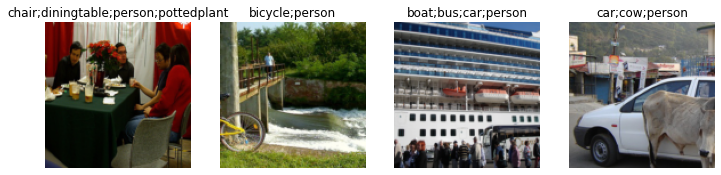

In [32]:
dls.show_batch(nrows=1, ncols=4)

In [33]:
dblock.summary(train_df)

Setting-up type transforms pipelines
0     000005.jpg           chair      True
1     000007.jpg             car      True
2     000009.jpg    horse person      True
3     000012.jpg             car     False
4     000016.jpg         bicycle      True
...          ...             ...       ...
5006  009954.jpg    horse person      True
5007  009955.jpg            boat      True
5008  009958.jpg  person bicycle      True
5009  009959.jpg             car     False
5010  009961.jpg             dog     False

[5011 rows x 3 columns]
Found 5011 items
2 datasets of sizes 2501,2510
Setting up Pipeline: get_x -> PILBase.create
Setting up Pipeline: get_y -> MultiCategorize -- {'vocab': None, 'sort': True, 'add_na': False} -> OneHotEncode -- {'c': None}

Building one sample
  Pipeline: get_x -> PILBase.create
    starting from
      fname       000012.jpg
labels             car
is_valid         False
Name: 3, dtype: object
    applying get_x gives
      /root/.fastai/data/pascal_2007/train/00001

## Create a Learner

In [51]:
learn = cnn_learner(dls, resnet18)

In [55]:
x,y = dls.one_batch()

In [57]:
learn.model.cuda()
activs = learn.model(x)
activs.shape

torch.Size([64, 20])

In [58]:
loss_func = nn.BCEWithLogitsLoss()
loss = loss_func(activs, y)
loss

TensorMultiCategory(1.0237, device='cuda:0', grad_fn=<AliasBackward0>)

In [60]:
def accuracy_multi(inp, targ, thresh=0.5, sigmoid=True):
    "Compute accuracy when `inp` and `targ` are the same size."
    inp,targ = flatten_check(inp,targ)
    if sigmoid: inp = inp.sigmoid()
    return ((inp>thresh)==targ.bool()).float().mean()

In [61]:
learn = cnn_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.2))
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.937040,0.703107,0.231255,00:41
1,0.816712,0.553716,0.297610,00:39
2,0.594855,0.201982,0.818386,00:39
3,0.357379,0.126414,0.939243,00:39


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.135984,0.115235,0.945578,00:42
1,0.118432,0.107029,0.952510,00:41
2,0.097207,0.103484,0.951155,00:41


## Check for different thresholds

In [63]:
learn.metrics = partial(accuracy_multi, thresh=0.1)
learn.validate()

(#2) [0.10348442941904068,0.9300398230552673]

In [64]:
learn.metrics = partial(accuracy_multi, thresh=0.99)
learn.validate()

(#2) [0.10348442941904068,0.944043755531311]

In [65]:
learn.metrics = partial(accuracy_multi, thresh=0.4)
learn.validate()

(#2) [0.10348442941904068,0.9618922472000122]

In [66]:
preds, targs = learn.get_preds()

In [67]:
accuracy_multi(preds, targs, thresh=0.9, sigmoid=False)

TensorBase(0.9569)

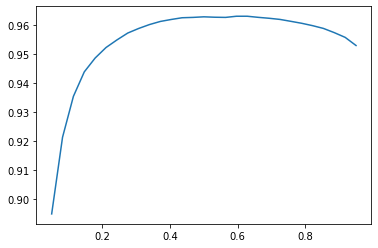

In [70]:
xs = torch.linspace(0.05, 0.95, 29)
accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs]
plt.plot(xs, accs);

In [72]:
learn.metrics = partial(accuracy_multi, thresh=0.4)
learn.validate()

(#2) [0.10348442941904068,0.9618922472000122]

In [80]:
ind = torch.argmax(Tensor(accs))
xs[ind]

tensor(0.5964)

In [78]:
learn.metrics = partial(accuracy_multi, thresh=0.6)
learn.validate()

(#2) [0.10348442941904068,0.9631076455116272]